In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import dask
import dask.dataframe as dd
import pandas as pd
from dask.delayed import delayed
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parts = dask.delayed(pd.read_excel)('AirQualityUCI.xlsx')
df = dd.from_delayed(parts)

df.compute()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [44]:
# -200 are nans

for i in df.columns[2:]:
    df[i] = df[i].replace(-200, df[i].mean())

# 2004-03-10
# Timestamp('2004-03-10 00:00:00')
# call date() on object to get 'datetime.date(2004, 3, 10)'
# attributes are year, month, day, weekday()

df['Year'] = df['Date'].map(lambda x: x.date().year - 2004, meta=('Date', 'i8'))
df['Month'] = df['Date'].map(lambda x: x.date().month, meta=('Date', 'i8'))
df['Weekday'] = df['Date'].map(lambda x: x.date().weekday(), meta=('Date', 'i8'))

# 18:00:00
# datetime.time(18, 0)
# attributes are hour, minute, second, microsecond
#            [0, 23], [0, 59], [0, 59], [0, 999999]

if type(df['Time'].compute()[0]) == str:
    df['Hour'] = df['Time'].map(lambda x: int(x[:2]), meta=('Time', 'i8'))
else:
    df['Hour'] = df['Time'].map(lambda x: x.hour, meta=('Time', 'i8'))

df.compute()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Weekday,Hour
0,2004-03-10,18:00:00,2.6,1360.00,150.000000,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754,0,3,2,18
1,2004-03-10,19:00:00,2.0,1292.25,112.000000,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487,0,3,2,19
2,2004-03-10,20:00:00,2.2,1402.00,88.000000,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239,0,3,2,20
3,2004-03-10,21:00:00,2.2,1375.50,80.000000,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713,0,3,2,21
4,2004-03-10,22:00:00,1.6,1272.25,51.000000,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794,0,3,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-159.090093,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824,1,4,0,10
9353,2005-04-04,11:00:00,2.4,1162.50,-159.090093,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864,1,4,0,11
9354,2005-04-04,12:00:00,2.4,1142.00,-159.090093,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649,1,4,0,12
9355,2005-04-04,13:00:00,2.1,1002.50,-159.090093,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866,1,4,0,13


In [3]:
del df['Date']
del df['Time']

columns = list(df.columns)
first_four_columns = columns[-4:]
remaining_columns = columns[:-4]

new_order = first_four_columns + remaining_columns
df = df[new_order]
df.compute()

,Year,Month,Weekday,Hour,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,3,2,18,2.6,1360.00,150.000000,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,0,3,2,19,2.0,1292.25,112.000000,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,0,3,2,20,2.2,1402.00,88.000000,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,0,3,2,21,2.2,1375.50,80.000000,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,0,3,2,22,1.6,1272.25,51.000000,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,1,4,0,10,3.1,1314.25,-159.090093,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,1,4,0,11,2.4,1162.50,-159.090093,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,1,4,0,12,2.4,1142.00,-159.090093,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,1,4,0,13,2.1,1002.50,-159.090093,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

scaler_pipeline = Pipeline([
    ('robust_scaler', RobustScaler()),
    ('standard_scaler', StandardScaler()),
    ('min_max_scaler', MinMaxScaler())
])

cols = list(df.columns)
scaled_data = scaler_pipeline.fit_transform(df)
df = dd.from_pandas(pd.DataFrame(scaled_data, columns=cols), npartitions=2)

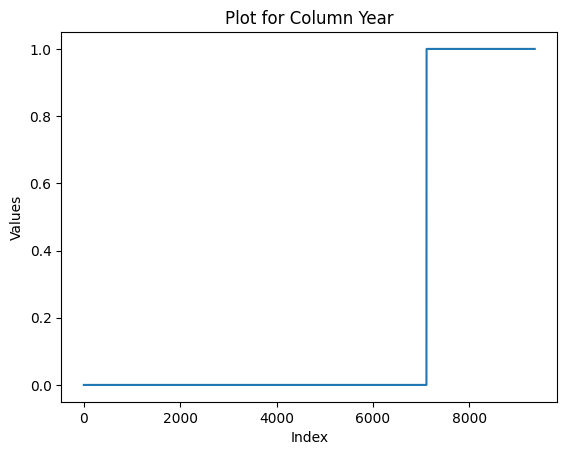

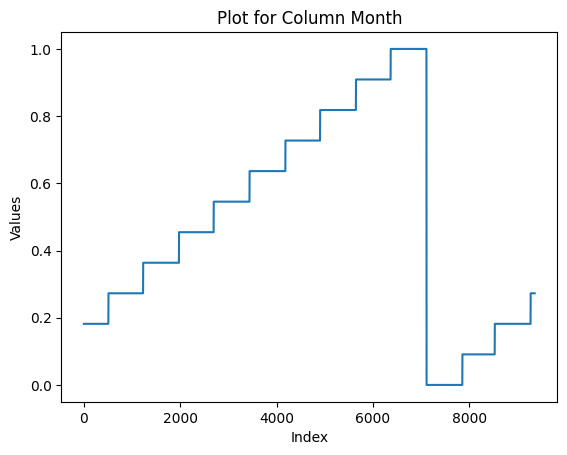

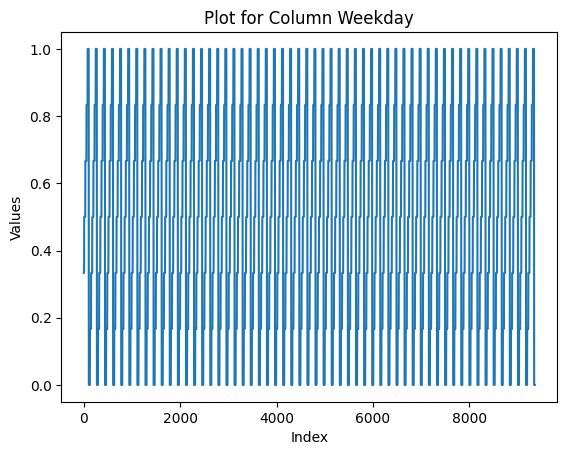

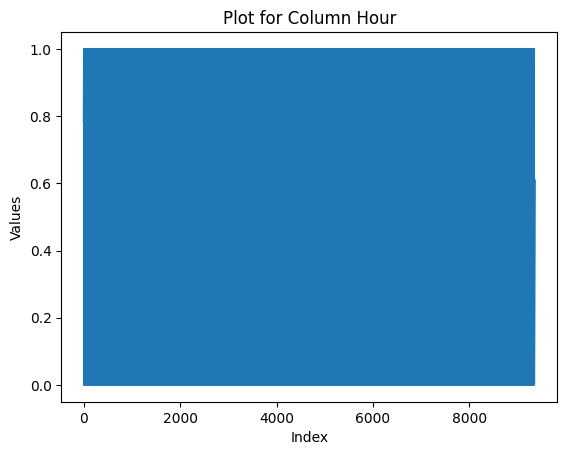

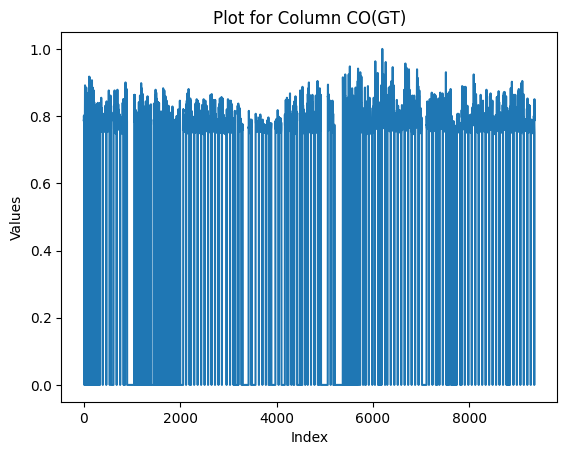

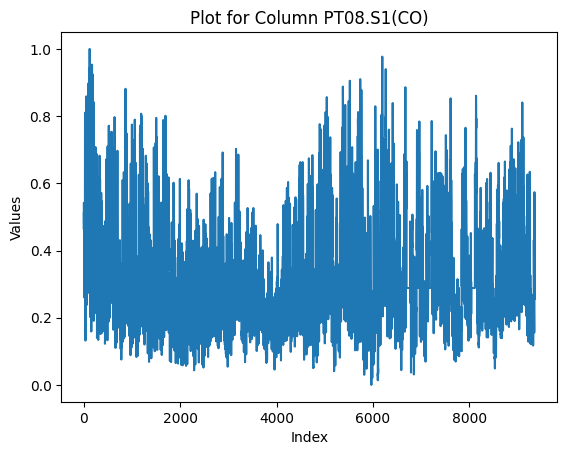

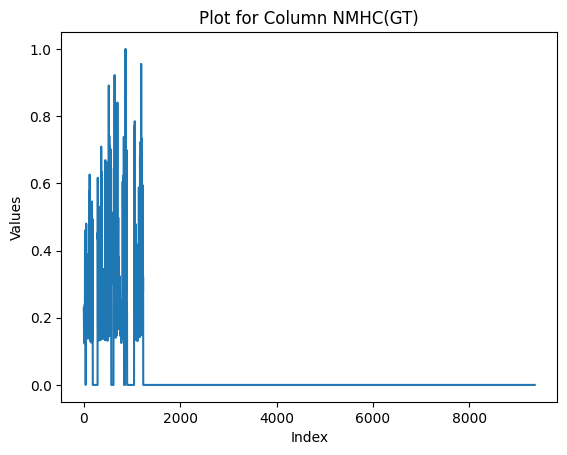

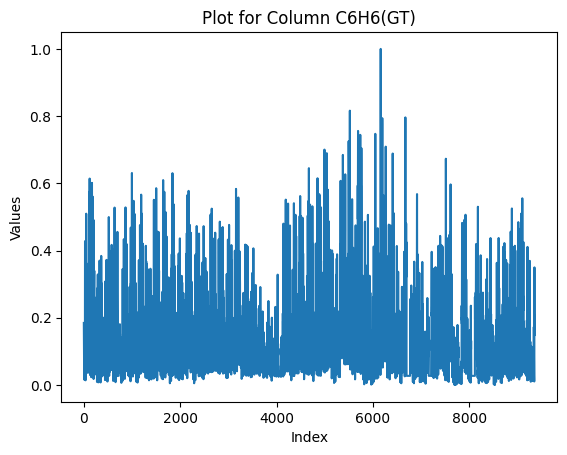

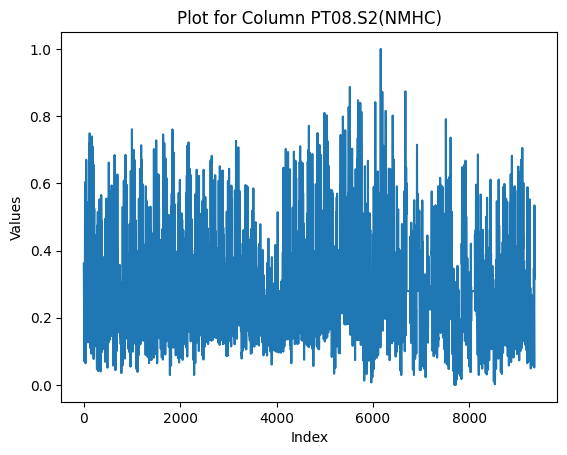

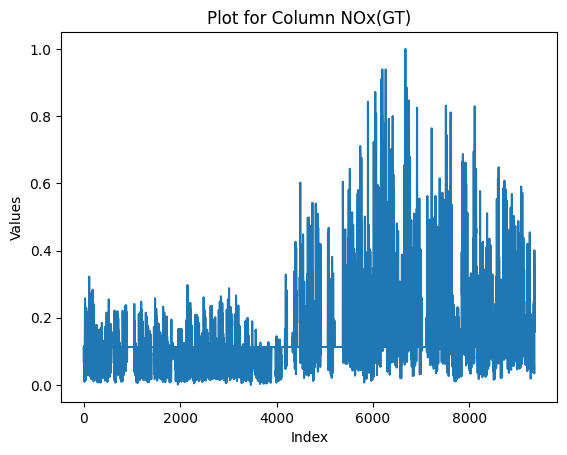

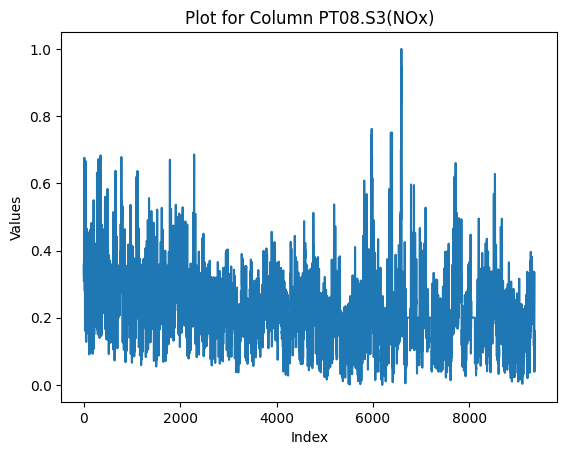

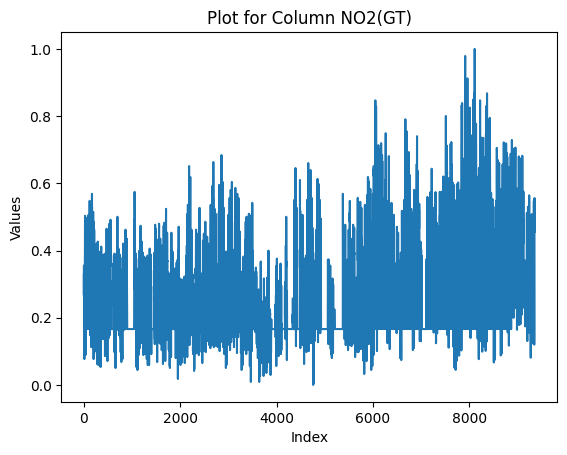

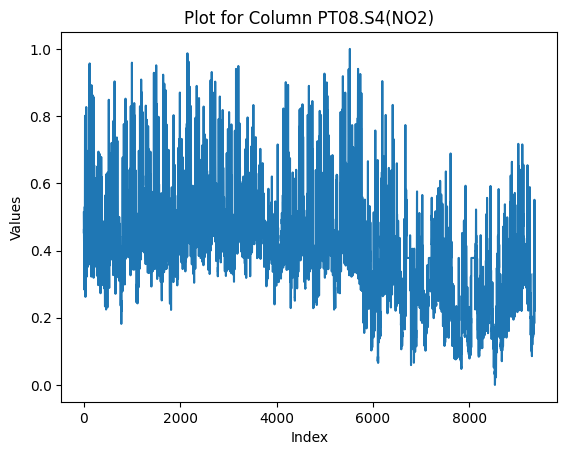

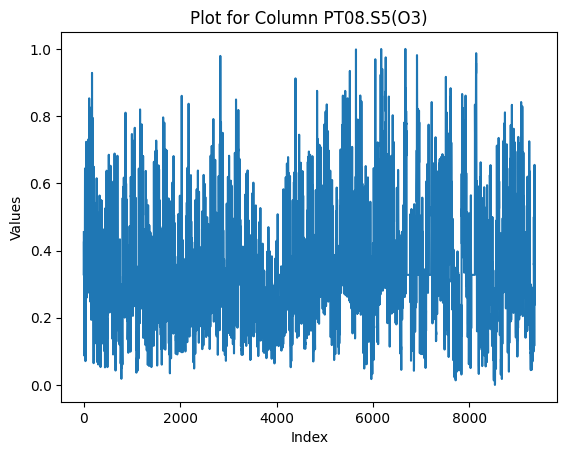

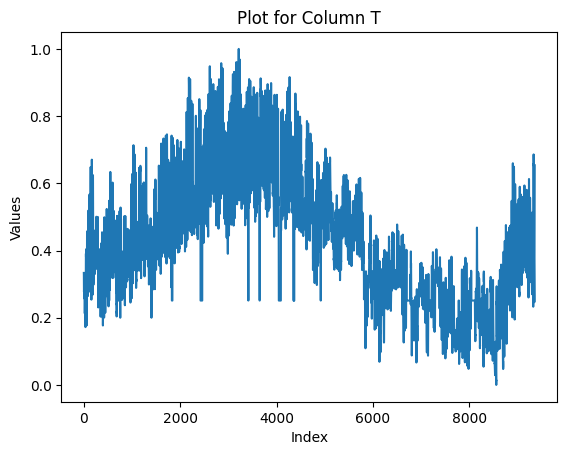

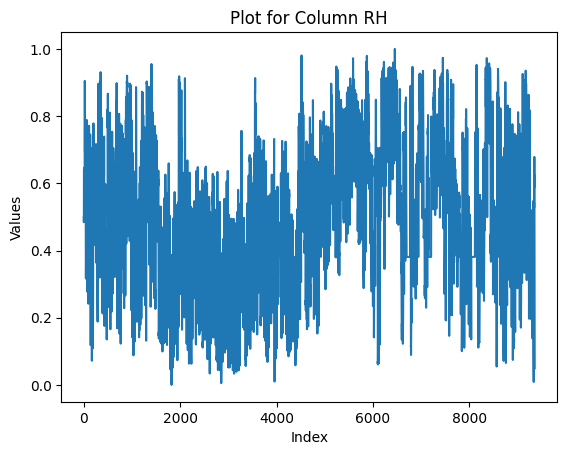

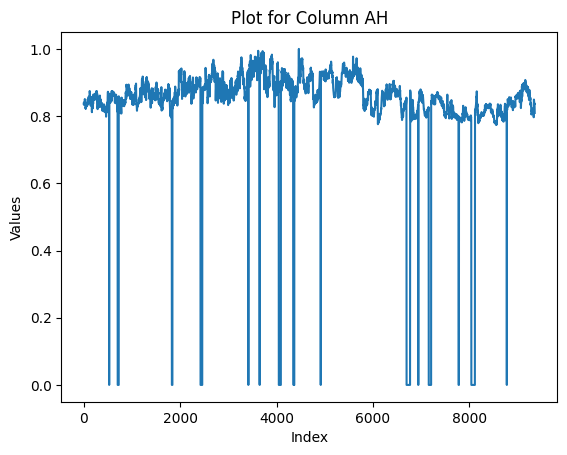

In [5]:
import matplotlib.pyplot as plt

a = df.compute()
# a = df[(df['Year'] == 0) & (df['Month'] == 3)].compute()

for col in a.columns:
    plt.figure()
    # plt.scatter(a.index, a[col], s=1)
    plt.plot(a.index, a[col])
    plt.title(f'Plot for Column {col}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.show()

In [6]:
df.compute()

,Year,Month,Weekday,Hour,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.0,0.181818,0.333333,0.782609,0.798298,0.511849,0.229280,0.184498,0.361737,0.111036,0.311024,0.328694,0.513040,0.454654,0.333333,0.499057,0.837541
1,0.0,0.181818,0.333333,0.826087,0.785285,0.463196,0.201092,0.145428,0.312167,0.068382,0.360796,0.266509,0.453125,0.326382,0.326882,0.484287,0.833983
2,0.0,0.181818,0.333333,0.869565,0.789622,0.542011,0.183289,0.139148,0.303701,0.087339,0.346500,0.331655,0.451214,0.370588,0.296774,0.563168,0.836712
3,0.0,0.181818,0.333333,0.913043,0.789622,0.522980,0.177355,0.142780,0.308617,0.115098,0.326168,0.355345,0.464366,0.426741,0.277419,0.638906,0.840734
4,0.0,0.181818,0.333333,0.956522,0.776609,0.448833,0.155843,0.100156,0.247030,0.087339,0.374034,0.337578,0.422212,0.386228,0.280645,0.633564,0.840964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,1.0,0.272727,0.000000,0.434783,0.809142,0.478995,0.000000,0.210411,0.392189,0.318009,0.091708,0.556115,0.370166,0.654936,0.510753,0.252357,0.837439
9353,1.0,0.272727,0.000000,0.478261,0.793960,0.370018,0.000000,0.176218,0.351632,0.237847,0.119348,0.524726,0.320369,0.455306,0.563978,0.182904,0.832481
9354,1.0,0.272727,0.000000,0.521739,0.793960,0.355296,0.000000,0.192248,0.371023,0.197021,0.119136,0.511401,0.310139,0.378408,0.619355,0.115336,0.824628
9355,1.0,0.272727,0.000000,0.565217,0.787453,0.255117,0.000000,0.147787,0.315308,0.157414,0.160754,0.455138,0.220324,0.238406,0.650000,0.054997,0.810647


In [7]:
# scaled_df = df.drop(columns=['CO(GT)', 'NMHC(GT)', 'AH'])
scaled_df = df.drop(columns=['CO(GT)', 'NMHC(GT)', 'AH', 'NOx(GT)', 'PT08.S4(NO2)', 'T', 'RH'])
scaled_df.compute()

,Year,Month,Weekday,Hour,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S5(O3)
0,0.0,0.181818,0.333333,0.782609,0.511849,0.184498,0.361737,0.311024,0.328694,0.454654
1,0.0,0.181818,0.333333,0.826087,0.463196,0.145428,0.312167,0.360796,0.266509,0.326382
2,0.0,0.181818,0.333333,0.869565,0.542011,0.139148,0.303701,0.346500,0.331655,0.370588
3,0.0,0.181818,0.333333,0.913043,0.522980,0.142780,0.308617,0.326168,0.355345,0.426741
4,0.0,0.181818,0.333333,0.956522,0.448833,0.100156,0.247030,0.374034,0.337578,0.386228
...,...,...,...,...,...,...,...,...,...,...
9352,1.0,0.272727,0.000000,0.434783,0.478995,0.210411,0.392189,0.091708,0.556115,0.654936
9353,1.0,0.272727,0.000000,0.478261,0.370018,0.176218,0.351632,0.119348,0.524726,0.455306
9354,1.0,0.272727,0.000000,0.521739,0.355296,0.192248,0.371023,0.119136,0.511401,0.378408
9355,1.0,0.272727,0.000000,0.565217,0.255117,0.147787,0.315308,0.160754,0.455138,0.238406


In [8]:
X = np.array(scaled_df.iloc[:, :7])
y = np.array(scaled_df.iloc[:, 7:])

In [9]:
X = X.reshape(3119, 3, 7)
y = y.reshape(3119, 3, 3)

In [10]:
X.shape, y.shape

((3119, 3, 7), (3119, 3, 3))

In [11]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [12]:
X_train.shape, X_test.shape, X_val.shape

((2495, 3, 7), (312, 3, 7), (312, 3, 7))

In [13]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.float)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

In [14]:
batch_size = 30

train_data = torch.utils.data.DataLoader(
    CustomDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0,
    pin_memory=False
)

test_data = torch.utils.data.DataLoader(
    CustomDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0,
    pin_memory=False
)

val_data = torch.utils.data.DataLoader(
    CustomDataset(X_val, y_val),
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0,
    pin_memory=False
)

In [15]:
class EB(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size):
        super().__init__()
        # self.model = nn.Sequential(
        #     nn.Conv1d(input_dim, output_dim, kernel_size),
        #     nn.BatchNorm1d(output_dim),
        #     nn.Sigmoid(),
        #     nn.AdaptiveAvgPool1d(1)
        # )
        self.conv1d = nn.Conv1d(input_dim, output_dim, kernel_size)
        self.batch_norm = nn.BatchNorm1d(output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        output = self.conv1d(input)
        output = self.batch_norm(output)
        output = self.sigmoid(output)
        return output
    
class CB(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_dim, output_dim, kernel_size, stride),
            nn.BatchNorm1d(output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

class CRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        self.expansion_cnn = nn.Sequential(
            EB(7, 14, 1),
            EB(14, 28, 1),
            EB(28, 56, 1)
        )
        
        self.rnn = nn.LSTM(input_size=input_dim, num_layers=layer_dim, hidden_size=hidden_dim, batch_first=True)
        
        # self.compression_cnn = nn.Sequential(
        #     CB(56, 28, 2, 2),
        #     CB(28, 14, 2, 2),
        #     CB(14, 7, 2, 2)
        # )
        
        self.compression_cnn = nn.Sequential(
            CB(56, 35, 2, 2),
            CB(35, 18, 2, 2),
            CB(18, 9, 2, 2)
        )
        
        # self.conv1d = nn.Conv1d(7, output_dim, kernel_size=1)
        self.conv1d = nn.Conv1d(9, output_dim, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        h0, c0 = self.init_hidden(input)
        
        output = self.expansion_cnn(input)
        # output = output.reshape(batch_size, 3, 56)
        # print(output.shape)
        output, (hn, cn) = self.rnn(output, (h0, c0))
        # print(output.shape)
        output = self.compression_cnn(output)
        # print(output.shape)
        # output = self.fc(output)
        output = self.conv1d(output)
        # print(output.shape)
        output = self.sigmoid(output)
        
        return output
    
    def init_hidden(self, input):
        h0 = torch.zeros(self.layer_dim, input.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, input.size(0), self.hidden_dim).to(device)
        return [t for t in (h0, c0)]
    
model = CRNN(input_dim=3, hidden_dim=24, layer_dim=50, output_dim=3).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=True, min_lr=1e-6)

epochs = 100

pts = []

for epoch in range(epochs):
    model.train()
    for i, (feature, label) in enumerate(train_data):
        optimizer.zero_grad()
        feature = feature.transpose(2, 1).to(device)
        y_pred = model(feature)
        y_pred = y_pred.transpose(2, 1)
        loss = criterion(y_pred, label.to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
    print(f'Epoch: {epoch+1} --- Loss: {loss.item()}')
    pts.append(loss.item())

Epoch: 1 --- Loss: 0.8218703269958496
Epoch: 2 --- Loss: 1.4560320377349854
Epoch: 3 --- Loss: 1.489796757698059
Epoch: 4 --- Loss: 0.8252655267715454
Epoch: 5 --- Loss: 0.9435548782348633
Epoch: 6 --- Loss: 0.3816823959350586
Epoch: 7 --- Loss: 0.8930546641349792
Epoch: 8 --- Loss: 0.671543300151825
Epoch: 9 --- Loss: 0.9540629386901855
Epoch: 10 --- Loss: 0.6620197296142578
Epoch: 11 --- Loss: 2.2916996479034424
Epoch: 12 --- Loss: 1.2499140501022339
Epoch: 13 --- Loss: 1.3397901058197021
Epoch: 14 --- Loss: 1.657336950302124
Epoch: 15 --- Loss: 0.9040263891220093
Epoch: 16 --- Loss: 1.2365360260009766
Epoch: 17 --- Loss: 1.652692437171936
Epoch: 18 --- Loss: 0.9714455604553223
Epoch: 19 --- Loss: 1.0528244972229004
Epoch: 20 --- Loss: 1.099914789199829
Epoch: 21 --- Loss: 0.5798308849334717
Epoch: 22 --- Loss: 0.986920177936554
Epoch: 23 --- Loss: 1.0344767570495605
Epoch: 24 --- Loss: 0.9329820871353149
Epoch: 25 --- Loss: 1.3021272420883179
Epoch: 26 --- Loss: 3.8769173622131348
E

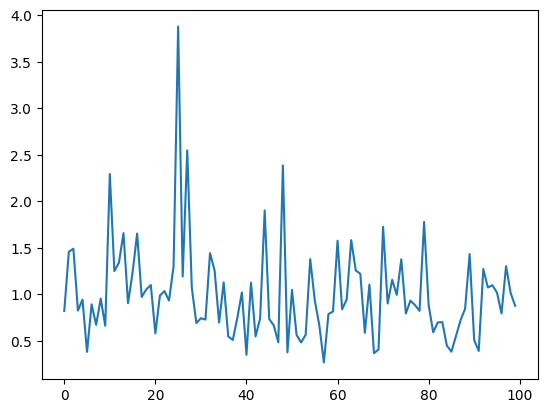

In [16]:
plt.plot(pts)